##### Llama 3.2 B architecture

![Llama 3.2.jpg](<attachment:Llama 3.2.jpg>)
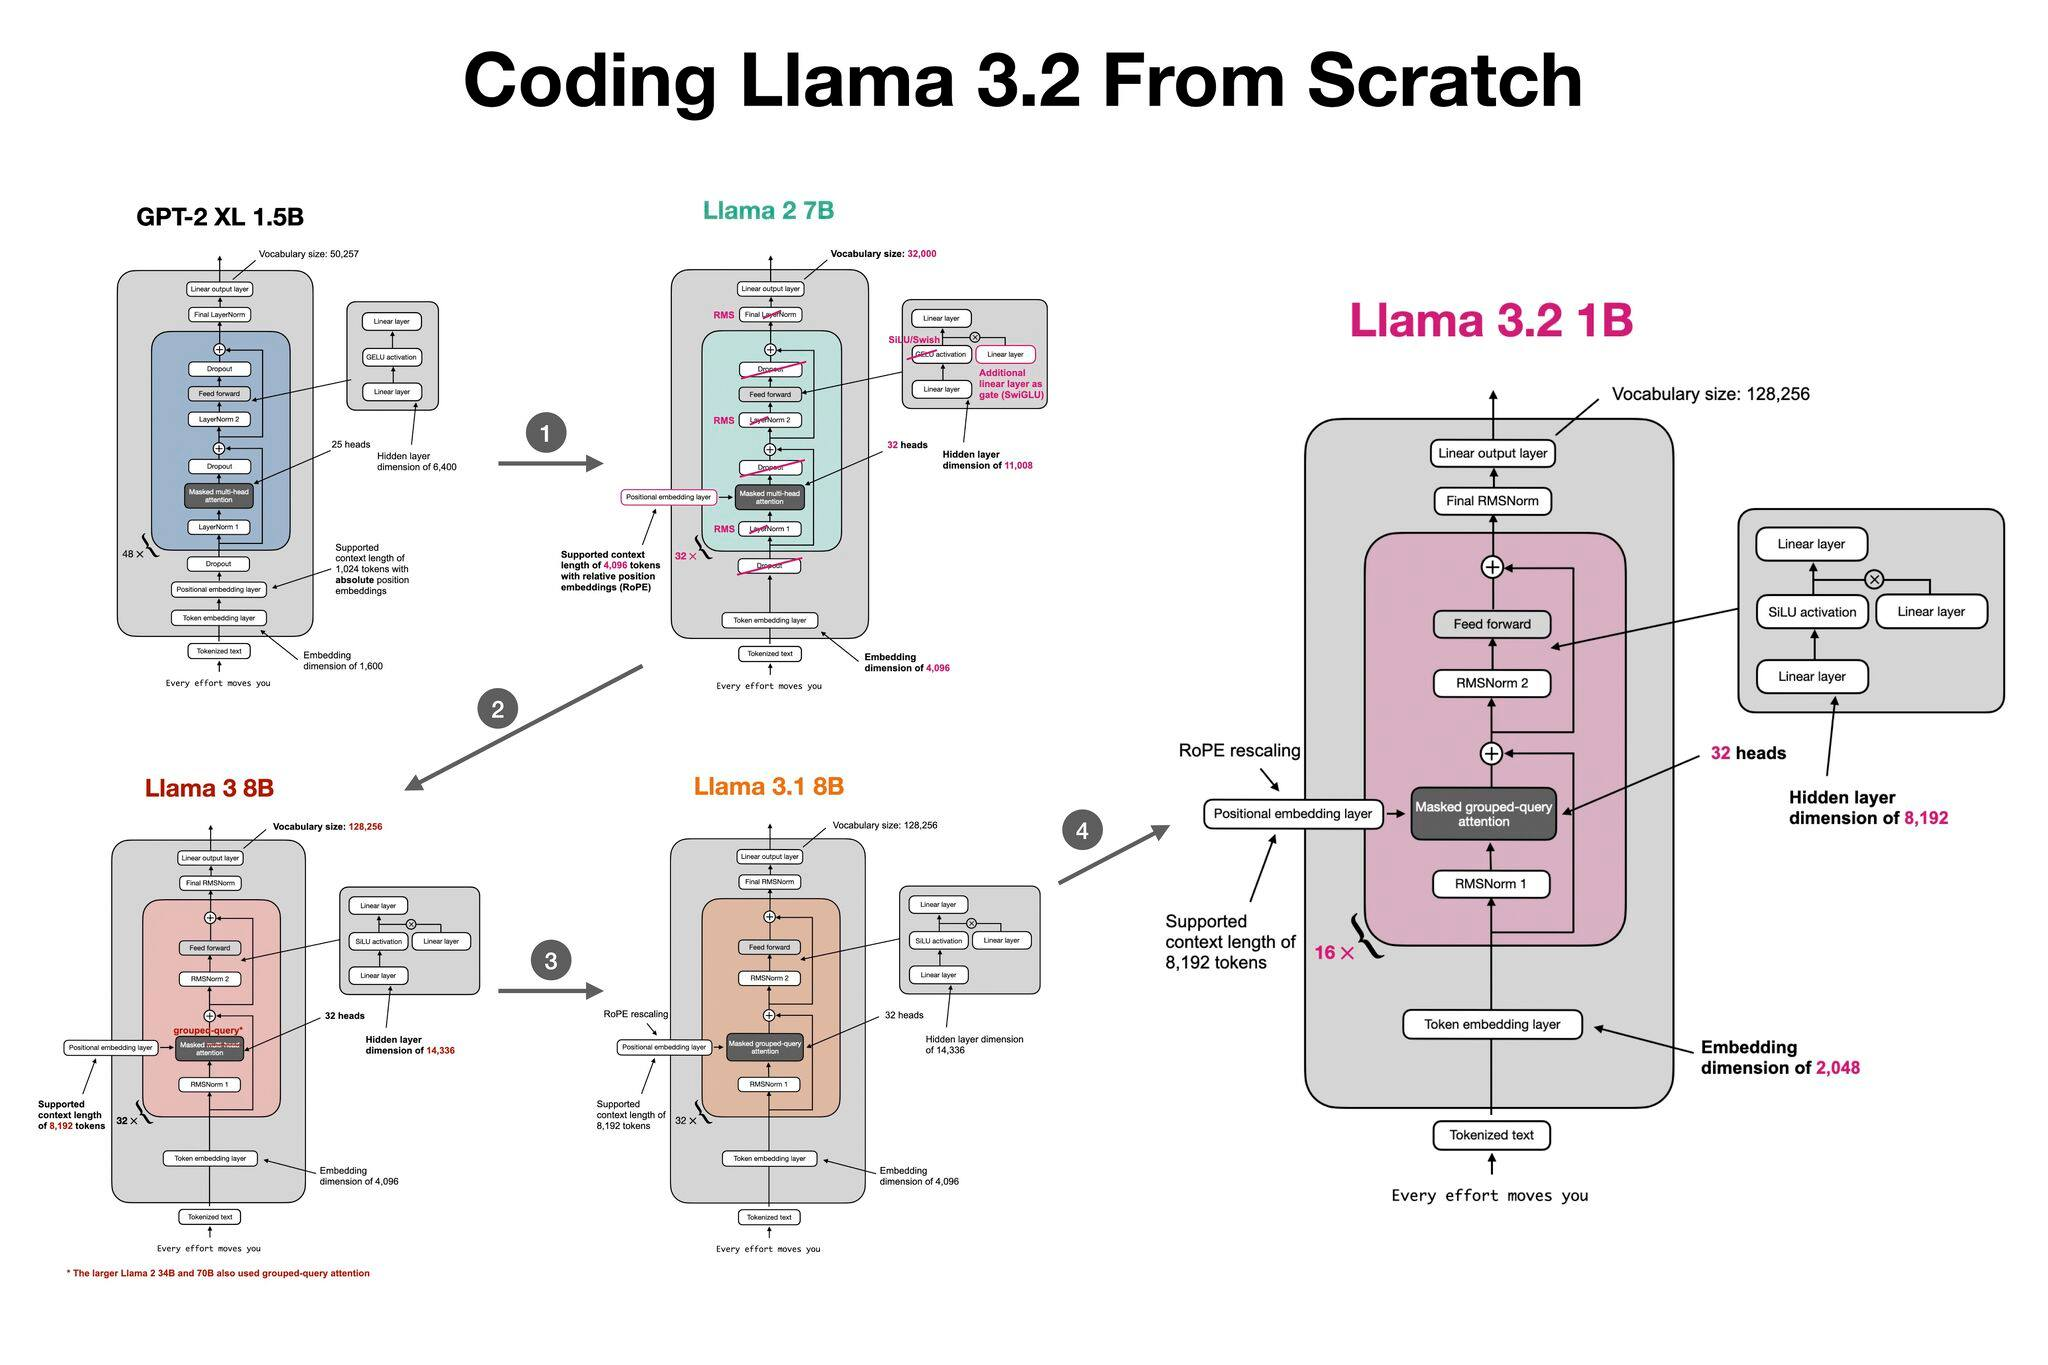

##### Import Libraries

In [3]:
## ShoW each Cell's Execution Time
# %pip install -q ipython-autotime  datasets  python-dotenv bitsandbytes
# %pip install -q --upgrade transformers
# %pip install --upgrade -q torch torchvision 
# %pip install -U -q ipython-autotime bitsandbytes

# %pip install --upgrade sagemaker
# %pip install --upgrade boto3 

%load_ext autotime


time: 0 ns (started: 2024-10-18 19:55:09 +03:00)


In [4]:
import torch 

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print(f" DEVICE: {DEVICE}. GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    DEVICE = 'cpu'
    print(f" DEVICE: {DEVICE}. No GPU available. Training will run on CPU.")

 DEVICE: cuda:0. GPU: NVIDIA GeForce RTX 4050 Laptop GPU is available.
time: 0 ns (started: 2024-10-18 19:55:11 +03:00)


In [ ]:
from utils import (
    download_from_s3, 
    upload_to_s3, 
    plot_multiple_results, 
    check_trainable_layers, 
    list_model_layers, 
    count_trainable_layers, 
    count_parameters, 
    unfreeze_BERT_layers, 
    unfreeze_all_Llama_layers, 
    plot_results, 
    rescale_matrix_layer_by_layer, 
    get_cuda_summary, 
    print_model_layers, 
    train_model, 
    evaluate_model, 
    plot_textDataset_distribution, 
    save_model, 
    save_model_to_s3, 
    CustomDataset
)

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
# import re
import os
import seaborn as sns
from functools import partial
import boto3

# from  utils import *
# from utils import plot_results, train_model, get_cuda_summary

import sys
#######################################################
#######################################################

# import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
# import torch.nn.functional as F
#######################################################
#######################################################

from transformers import  AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, RandomSampler
from datasets import load_dataset
from torch.utils.data import Subset, Dataset
from torch.nn.utils.rnn import pad_sequence

# from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast

#######################################################
#######################################################
import warnings
import logging
# import sys
# import json
from dotenv import load_dotenv

#######################################################
#######################################################



time: 2.77 s (started: 2024-10-18 19:55:12 +03:00)


In [6]:
## Local Vscode
# load_dotenv()
# HF_TOKEN = os.getenv('TF_TOKEN')

## kaggle
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

## from huggingface_hub import login, HfFolder
# ## Colab
# from google.colab import userdata
# HF_TOKEN= userdata.get('HF_TOKEN')

## Log in to Hugging Face Hub
# login(token=HF_TOKEN, )

# 

time: 0 ns (started: 2024-10-18 19:55:15 +03:00)


In [7]:
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
logging.getLogger("transformers").setLevel(logging.ERROR)

time: 0 ns (started: 2024-10-18 19:55:15 +03:00)


##### Data Parallelism #################################################

In [ ]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

https://sagemaker.readthedocs.io/en/stable/api/training/sdp_versions/v1.0.0/smd_data_parallel_pytorch.html

In [ ]:
## With Data Parallelism Only (Not FSDP)
## PyTOrch 1.6 Python 3.6 GPU optimized 

# import smdistributed.dataparallel.torch.torch_smddp
# torch.distributed.init_process_group("smddp")

import smdistributed.dataparallel.torch.distributed as dist
from smdistributed.dataparallel.torch.parallel.distributed import DistributedDataParallel as DDP

dist.init_process_group()

In [ ]:
import torch.distributed as dist 
from torch.nn.parallel import DistributedDataParallel as DDP

dist.init_process_group()

- Pin GPU to parallel process

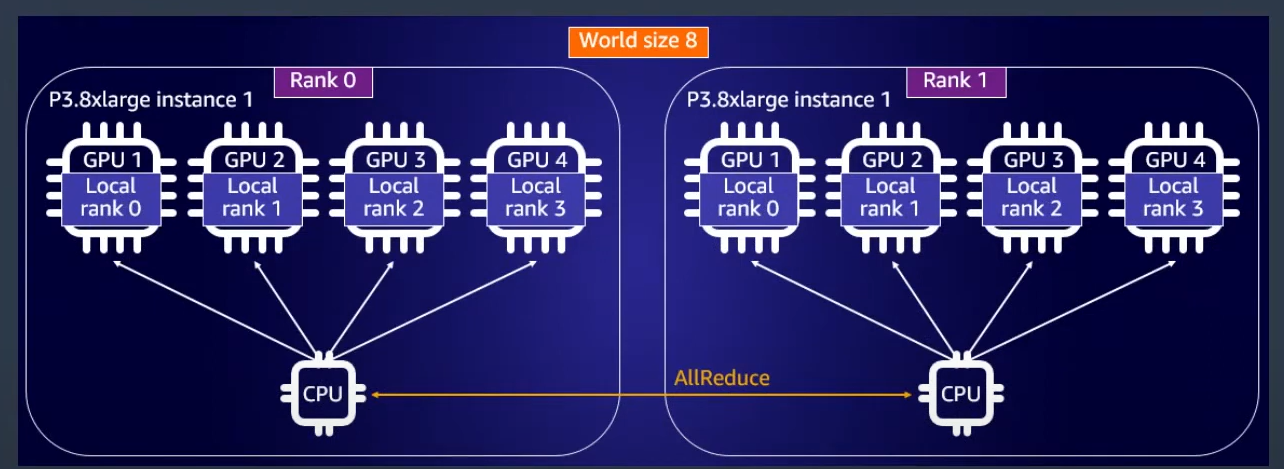

In [4]:
local_rank = dist.get_local_rank()  # Get the local rank for the current process
rank = dist.get_rank()
world_size = dist.get_world_size()

torch.cuda.set_device(local_rank)  # Set the current CUDA device to the local rank



time: 395 μs (started: 2024-10-16 17:25:14 +00:00)


In [5]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()


time: 1.41 ms (started: 2024-10-16 17:25:14 +00:00)


- Wrap Model in object

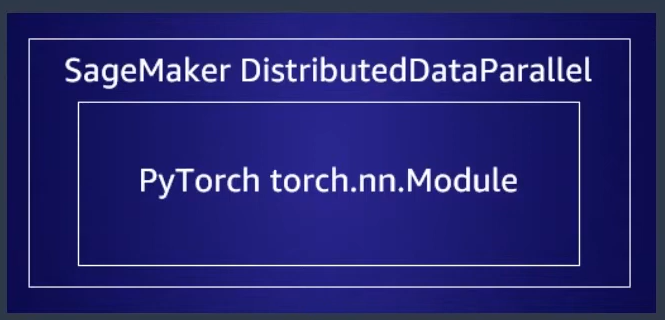

In [ ]:
# Load the tokenizer and model
model_name = "meta-llama/Llama-3.2-1B"
llama32_1B_tokenizer = AutoTokenizer.from_pretrained(model_name,token=HF_TOKEN)
llama32_1B_tokenizer.pad_token = llama32_1B_tokenizer.eos_token
llama32_1B_tokenizer.padding_side = 'right'

llama32_1B_model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.bfloat16, 
    token=HF_TOKEN
    )


# wrap the model
llama32_1B_model_DDP = DDP(llama32_1B_model)


In [15]:
# thepile_10k_train_subset = thepile_10k['train'].select(range(10))

time: 0 ns (started: 2024-10-18 19:56:33 +03:00)


In [ ]:
# Llama32_1B_MAX_LENGTH = 8
# NUM_SAMPLES = 10


# thepile_10k = load_dataset("NeelNanda/pile-10k")

# train_dataset = thepile_10k['train']
# train_dataset = thepile_10k['train'].select(range(NUM_SAMPLES))



# thepile_10k_train_dataset = CustomDataset(
#     train_dataset['text'],
#     tokenizer=llama32_1B_tokenizer,
#     max_length=16
#     )

# train_dataloader = DataLoader(
#     thepile_10k_train_dataset, 
#     batch_size=1, 
#     collate_fn=collate_fn,
#     shuffle=True, 
#     pin_memory=True
#     )
# val_dataloader = DataLoader(
#     thepile_10k_train_dataset, 
#     batch_size=1, 
#     collate_fn=collate_fn, 
#     shuffle=True, 
#     pin_memory=True)


- Set Sampler attributes

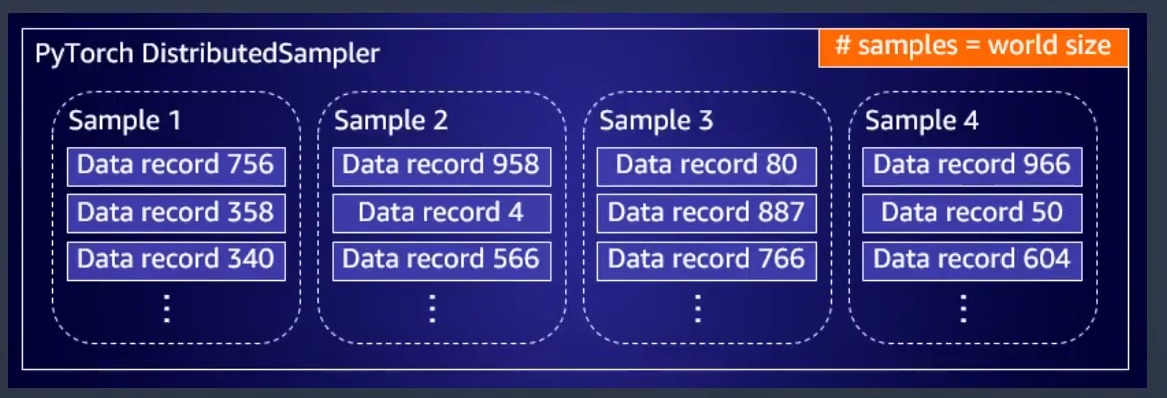

In [ ]:
# from torch.utils.data.distributed import DistributedSampler

# train_sampler = DistributedSampler(
#     train_dataset,
#     num_replicas=world_size,
#     rank=rank
# )

time: 498 ms (started: 2024-10-16 17:25:15 +00:00)


- Save Checkpoints on leader node only

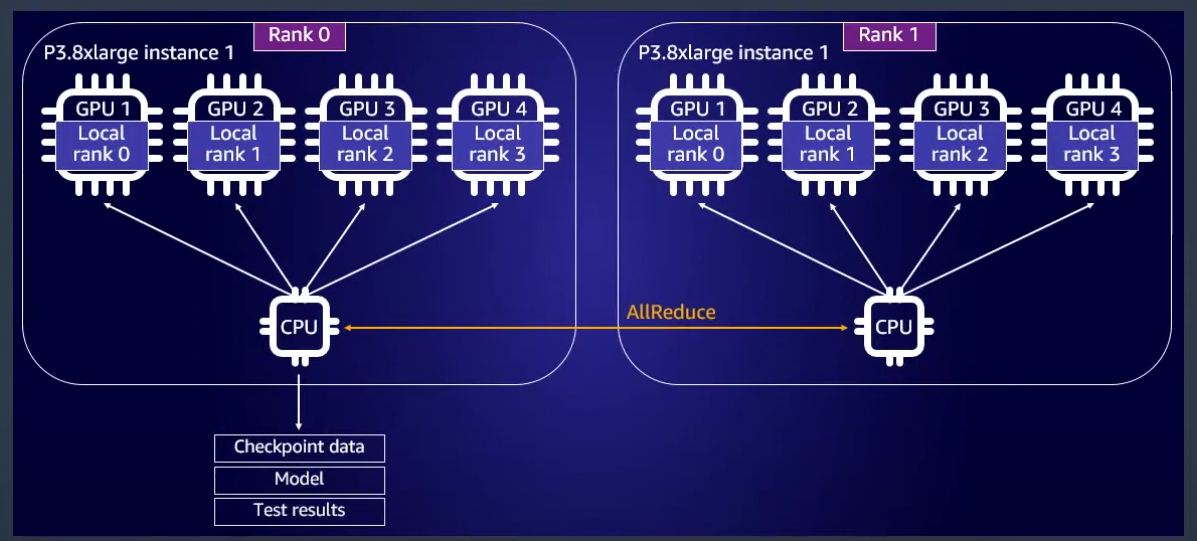

In [ ]:
rank = dist.get_rank()
model_directory = ''
from utils import save_model
if rank==0:
    save_model(llama32_1B_model, model_directory)
    ...#save checkpoints
else:
    ... #Do not save checkpoints

- Enable data parallelism

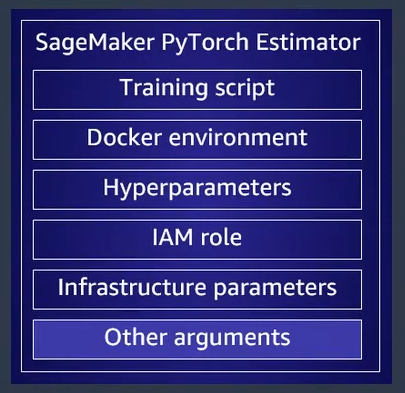

In [ ]:
hyperparameters = {
    'epochs': 1,
    'batch_size': 1,
    'test-batch-size': 1,
     "lr": 1.0e-5,
    'num_samples':16, #-1 for all
    # "max_steps": 100,
    "seed": 12345,
    'max_context_length':8192,
    'saving_dir': '/',
    's3_path':''
}

In [7]:
from sagemaker.pytorch import PyTorch


# Updated the base job name and entry point
estimator = PyTorch(
    base_job_name='DDP-training',  # Updated base job name
    source_dir='code',
    entry_point='train_Llama2_1B.py',  # Updated entry point
    role=role,
    framework_version='1.15.2',
    py_version='py39',
    instance_count=world_size,
    instance_type='ml.p4de.24xlarge',
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
    # distribution={
    #     'smdistributed': {
    #         'dataparallel': {
    #             'enabled': True
    #         }
    #     }
    # },
        distribution={
        'torch_distributed': {
            'enabled': True
        }
    },
    debugger_hook_config=False
)


time: 420 μs (started: 2024-10-16 17:25:14 +00:00)


In [ ]:
estimator.fit()

In [ ]:
import boto3
from sagemaker.pytorch import PyTorch


# Step 3: Retrieve the model from the estimator
# The model is saved automatically to the specified S3 output path
model_artifact = estimator.model_data  # Get the S3 URI of the trained model

# Step 4: (Optional) Download the model locally
s3 = boto3.client('s3')

# Parse the bucket name and object key from the model_artifact
bucket_name = model_artifact.split('/')[2]
object_key = '/'.join(model_artifact.split('/')[3:])

# Download the model
local_file_path = 'model.tar.gz'  # Adjust as necessary
s3.download_file(bucket_name, object_key, local_file_path)

print(f'Model saved in S3 at {model_artifact} and downloaded locally to {local_file_path}.')


##### SageMaker GPUs

In [1]:
import torch 

# Get number of GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

# Print the names of available GPUs
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
import sagemaker

sess = sagemaker.Session()

# optionally point to whichever bucket you have access to 
bucket = sess.default_bucket()

In [ ]:
s3_train_path = 's3://{}/data/mnist/'.format(bucket)

In [ ]:
from sagemaker.pytorch import PyTorch

EPOCHS = 5
BATCH_SIZE = 1 
ROLE = 'SageMakerDataScientist'
INSTANCE_COUNT = 1
INSTANCE_TYPE = 'ml.p4de.24xlarge'

estimator = PyTorch(
    entry_point='trainLlama32-1B.py',  # Your script with GPU assignment
    role=ROLE,
    instance_count=INSTANCE_COUNT,  # Number of instances
    instance_type=INSTANCE_TYPE,  # Choose an instance type with GPUs
    framework_version='1.9',  # PyTorch version
    py_version='py38',
    hyperparameters={
        'epochs': 10,
        'batch_size': 32,
    },
    # Specify the distribution strategy if you want data parallelism
    distribution={
        'torch_distributed': {
            'enabled': True
        }
    }
)

# Fit the model
estimator.fit('s3://bucket/path/to/dataset')

##### Multi Processing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.multiprocessing import Process


# Define a function to train a model on a specific GPU
def train_model_on_gpu(Model, gpu_id):
    device = torch.device(f'cuda:{gpu_id}')
    
    # Initialize the model and move it to the specific GPU
    model = Model().to(device)
    
    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        inputs = torch.randn(64, 10).to(device)  # Example random input data
        targets = torch.randn(64, 1).to(device)  # Example random target data
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'GPU {gpu_id} - Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Main function to spawn processes for each GPU
def main():
    num_gpus = 8  # Assuming 8 GPUs are available
    processes = []

    # Spawn a process for each GPU
    for gpu_id in range(num_gpus):
        p = Process(target=train_model_on_gpu, args=(gpu_id,))
        p.start()
        processes.append(p)

    # Join all processes (wait for them to finish)
    for p in processes:
        p.join()

if __name__ == '__main__':
    main()






##### Llama-3.2 1B from Hugging Face bfp-16:

In [19]:
# Load the tokenizer and model
model_name = "meta-llama/Llama-3.2-1B"
llama32_1B_tokenizer = AutoTokenizer.from_pretrained(model_name,token=HF_TOKEN)
llama32_1B_tokenizer.pad_token = llama32_1B_tokenizer.eos_token
llama32_1B_tokenizer.padding_side = 'right'

time: 453 ms (started: 2024-10-18 19:58:06 +03:00)


In [20]:
# llama32_1B_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, token=HF_TOKEN)
llama32_1B_model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.bfloat16, 
    token=HF_TOKEN
    )

time: 1.34 s (started: 2024-10-18 19:58:06 +03:00)


In [14]:
llama32_1B_model.device

device(type='cpu')

time: 1.65 ms (started: 2024-10-16 17:25:16 +00:00)


In [15]:
llama32_1B_model.to(DEVICE)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

time: 935 ms (started: 2024-10-16 17:25:16 +00:00)


In [16]:
llama32_1B_model.device

device(type='cuda', index=0)

time: 1.5 ms (started: 2024-10-16 17:25:17 +00:00)


In [17]:
# Print all layers of the model
# print_model_layers(llama32_1B_model)

time: 894 μs (started: 2024-10-16 17:25:17 +00:00)


In [18]:
# check_trainable_layers(llama32_1B_model)

time: 1.18 ms (started: 2024-10-16 17:25:17 +00:00)


In [19]:
# Unfreeze model layers:
for param in llama32_1B_model.parameters():
    if param.dtype in [torch.float32, torch.float64, torch.float16, torch.bfloat16]:
        param.requires_grad = True
    else:
        param.requires_grad = False

time: 1.29 ms (started: 2024-10-16 17:25:17 +00:00)


In [20]:
from utils import check_trainable_layers
check_trainable_layers(llama32_1B_model)

model.embed_tokens.weight is || TRAINABLE || 
model.layers.0.self_attn.q_proj.weight is || TRAINABLE || 
model.layers.0.self_attn.k_proj.weight is || TRAINABLE || 
model.layers.0.self_attn.v_proj.weight is || TRAINABLE || 
model.layers.0.self_attn.o_proj.weight is || TRAINABLE || 
model.layers.0.mlp.gate_proj.weight is || TRAINABLE || 
model.layers.0.mlp.up_proj.weight is || TRAINABLE || 
model.layers.0.mlp.down_proj.weight is || TRAINABLE || 
model.layers.0.input_layernorm.weight is || TRAINABLE || 
model.layers.0.post_attention_layernorm.weight is || TRAINABLE || 
model.layers.1.self_attn.q_proj.weight is || TRAINABLE || 
model.layers.1.self_attn.k_proj.weight is || TRAINABLE || 
model.layers.1.self_attn.v_proj.weight is || TRAINABLE || 
model.layers.1.self_attn.o_proj.weight is || TRAINABLE || 
model.layers.1.mlp.gate_proj.weight is || TRAINABLE || 
model.layers.1.mlp.up_proj.weight is || TRAINABLE || 
model.layers.1.mlp.down_proj.weight is || TRAINABLE || 
model.layers.1.input_laye

In [22]:
# # Check GPU memory allocated and cached
print(f"Allocated memory: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")
print(f"Cached memory: {torch.cuda.memory_reserved() / (1024**3):.2f} GB")


Allocated memory: 2.30 GB
Cached memory: 2.30 GB
time: 933 μs (started: 2024-10-16 17:25:17 +00:00)


In [23]:
!nvidia-smi

Wed Oct 16 17:25:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:00:16.0 Off |                    0 |
| N/A   36C    P0              67W / 300W |   2669MiB / 32768MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   5  Tesla V100-SXM2-32GB           On  | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P0              41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   6  Tesla V100-SXM2-32GB           On  | 00000000:00:1C.0 Off |                    0 |
| N/A   29C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   7  Tesla V100-SXM2-32GB           On  | 00000000:00:1D.0 Off |                    0 |
| N/A   28C    P0              41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

In [24]:
torch.cuda.empty_cache()

time: 413 μs (started: 2024-10-16 17:25:18 +00:00)


##### The pile_10k
The pile has been permanantly taken down due to copytright reasons.
https://techcrunch.com/2023/07/18/thousands-of-authors-sign-letter-urging-ai-makers-to-stop-stealing-books/

In [25]:
## Load the tokenizer and model
model_name = "meta-llama/Llama-3.2-1B"
llama32_1B_tokenizer = AutoTokenizer.from_pretrained(model_name,token=HF_TOKEN)
llama32_1B_tokenizer.pad_token = llama32_1B_tokenizer.eos_token
llama32_1B_tokenizer.padding_side = 'right'

# llama32_1B_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, token=HF_TOKEN)
llama32_1B_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, token=HF_TOKEN)

llama32_1B_model.to(DEVICE)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

time: 1.41 s (started: 2024-10-16 17:25:22 +00:00)


In [26]:
Llama32_1B_MAX_LENGTH = 1024
# Llama32_1B_MAX_LENGTH = 4096
# MAX_LENGTH = 256
NUM_SAMPLES = 20


time: 310 μs (started: 2024-10-16 17:25:23 +00:00)


In [27]:
thepile_10k = load_dataset("NeelNanda/pile-10k")


time: 431 ms (started: 2024-10-16 17:25:23 +00:00)


In [28]:
thepile_10k

DatasetDict({
    train: Dataset({
        features: ['text', 'meta'],
        num_rows: 10000
    })
})

time: 1.64 ms (started: 2024-10-16 17:25:24 +00:00)


In [29]:
# import random
## Print random item from the data set
# print(thepile_10k['train'][random.randint(0,9999)]['text']) # type: ignore

time: 572 μs (started: 2024-10-16 17:23:25 +00:00)


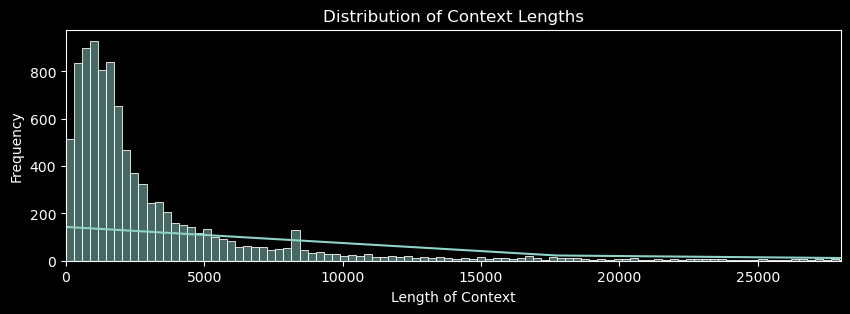

time: 13 s (started: 2024-10-16 17:23:25 +00:00)


In [30]:
thepile_10k_train = thepile_10k['train']
thepile_10k_train = thepile_10k_train.add_column("Context_length", [len(text) for text in thepile_10k_train["text"]])

plot_textDataset_distribution(thepile_10k_train)

In [31]:
thepile_10k_train_subset = thepile_10k['train'].select(range(NUM_SAMPLES))



time: 2.78 ms (started: 2024-10-16 17:23:38 +00:00)


In [11]:
## We tokenize the item when getting it from the dataset
class CustomDataset(torch.utils.data.Dataset):
    # Tokenization on-the-fly (slower, less RAM usage)
    def __init__(self, texts, tokenizer, max_length=None):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length        
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        tokenized_text = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        # tokenized_text = self.tokenizer(text, max_length=self.max_length, truncation=True, padding=False, return_tensors="pt")
        
        # print("tokenized_text input_ids length:", tokenized_text['input_ids'].size(1))
        return {
            "input_ids": tokenized_text['input_ids'].squeeze(0),
            "attention_mask": tokenized_text['attention_mask'].squeeze(0)
            }

# class CustomDataset(torch.utils.data.Dataset):
#     # Pre-tokenization (faster, more RAM usage)
#     def __init__(self, texts, tokenizer, max_length=None):
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.tokenized_texts = [self.tokenizer(text, max_length=self.max_length, truncation=True, padding=False, return_tensors="pt") for text in texts]
#     def __len__(self):
#         return len(self.tokenized_texts)
#     def __getitem__(self, idx):
#         tokenized_text = self.tokenized_texts[idx]
#         print("tokenized_text length:", tokenized_text['input_ids'].size(1))  # size(1) gets the sequence length dimension
#         return {
#             "input_ids": tokenized_text['input_ids'].squeeze(0),
#             "attention_mask": tokenized_text['attention_mask'].squeeze(0)
#             }

time: 0 ns (started: 2024-10-18 19:55:43 +03:00)


In [12]:
# define collate function that returns the collate string for each tokenized text 
def collate_fn(batch):
    input_ids = [ item['input_ids'] for item in batch ]
    attention_masks = [ item['attention_mask'] for item in batch ]
    return {
        'input_ids': pad_sequence(input_ids, batch_first=True, padding_value=llama32_1B_tokenizer.pad_token_id),
        'attention_mask': pad_sequence(attention_masks, batch_first=True, padding_value=0)
        }

time: 0 ns (started: 2024-10-18 19:55:43 +03:00)


In [34]:
Llama32_1B_MAX_LENGTH = 1024
# Llama32_1B_MAX_LENGTH = 4096
# MAX_LENGTH = 128
NUM_SAMPLES = 10

time: 1.73 ms (started: 2024-10-16 17:23:38 +00:00)


In [37]:
# return collate_fn with additional attributes for each input sequence and attention mask for each attention mask
max_length = Llama32_1B_MAX_LENGTH

thepile_10k_train_dataset = CustomDataset(
    thepile_10k_train_subset['text'],
    tokenizer=llama32_1B_tokenizer,
    # max_length=Llama32_1B_MAX_LENGTH
    max_length=max_length
    )

# Create dataloaders
train_dataloader = DataLoader(thepile_10k_train_dataset, batch_size=1, collate_fn=collate_fn ,shuffle=True, pin_memory=True)
val_dataloader = DataLoader(thepile_10k_train_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True, pin_memory=True)



time: 1.24 ms (started: 2024-10-16 16:56:48 +00:00)


In [38]:
for batch_idx, batch in enumerate(train_dataloader):
    print("")





















time: 46.9 ms (started: 2024-10-16 16:56:48 +00:00)


In [39]:
## Test the model parameters data type (fp16 or fp32 or bf16)
## Check the model's current data type for parameters and convert them to half precision (float16)
# for param in llama32_1B_model.parameters():
#     if param.dtype == torch.float32:
#         print("Model parameters are in float32 data type.")
#     elif param.dtype == torch.float16:
#         print("Model parameters are in float16 data type.")
#     elif param.dtype == torch.bfloat16:
#         print("Model parameters are in bfloat16 data type.")

time: 335 μs (started: 2024-10-16 16:56:48 +00:00)


##### Train

- Testing the convergence of the model

In [40]:
# print(torch.cuda.memory_summary())


time: 168 μs (started: 2024-10-16 16:56:48 +00:00)


In [41]:
!nvidia-smi

Wed Oct 16 16:56:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:00:16.0 Off |                    0 |
| N/A   33C    P0              67W / 300W |   5027MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   4  Tesla V100-SXM2-32GB           On  | 00000000:00:1A.0 Off |                    0 |
| N/A   28C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   5  Tesla V100-SXM2-32GB           On  | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P0              41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   6  Tesla V100-SXM2-32GB           On  | 00000000:00:1C.0 Off |                    0 |
| N/A   29C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

In [42]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Disable tokenizers parallelism to avoid warning


time: 531 μs (started: 2024-10-16 16:56:49 +00:00)


In [43]:
EPOCHS = 2
LR_TRAIN = 5e-5
ADAMW_OPTIMIZER = AdamW(llama32_1B_model.parameters(),lr=LR_TRAIN)

llama32_1B_losses = train_model(
    llama32_1B_model,
    optimizer=ADAMW_OPTIMIZER,
    epochs=EPOCHS,
    train_loader=train_dataloader,
    validation_loader=val_dataloader,
    patience=2,
    train_verbose=True,
    eval_verbose=True,
    with_autocast=False,
)

# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: 

100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


# Validation loss: 6.78 
# Epoch: 1 (Learning rate: 5e-05) 

100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


 Training loss: 1.64 || Validation loss: 0.94
# Epoch: 2 (Learning rate: 5e-05) 

100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


 Training loss: 0.90 || Validation loss: 0.78
time: 1min 5s (started: 2024-10-16 16:56:49 +00:00)


In [44]:
!nvidia-smi 

Wed Oct 16 16:57:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:00:16.0 Off |                    0 |
| N/A   45C    P0              70W / 300W |  17063MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

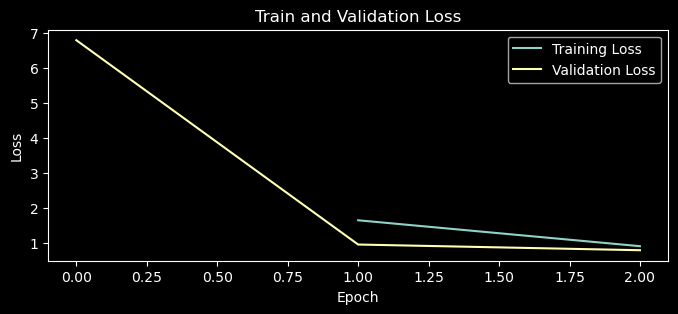

time: 204 ms (started: 2024-10-16 16:57:56 +00:00)


In [45]:
# Plot losses:
plot_results(llama32_1B_losses)

In [46]:
# Check GPU memory allocated and cached
print(f"Allocated memory: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")
print(f"Cached memory: {torch.cuda.memory_reserved() / (1024**3):.2f} GB")

Allocated memory: 11.53 GB
Cached memory: 16.29 GB
time: 1.11 ms (started: 2024-10-16 16:57:56 +00:00)


In [47]:
get_cuda_summary()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  11806 MiB |  16207 MiB |   1287 GiB |   1275 GiB |
|       from large pool |  11806 MiB |  16142 MiB |   1265 GiB |   1254 GiB |
|       from small pool |      0 MiB |     99 MiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  11806 MiB |  16207 MiB |   1287 GiB |   1275 GiB |
|       from large pool |  11806 MiB |  16142 MiB |   1265 GiB |

In [68]:
# Empty GPU cache
torch.cuda.empty_cache()

time: 429 μs (started: 2024-10-14 15:40:53 +00:00)


In [38]:
!nvidia-smi

Wed Oct 16 17:16:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:00:16.0 Off |                    0 |
| N/A   61C    P0              78W / 300W |  24659MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


|   4  Tesla V100-SXM2-32GB           On  | 00000000:00:1A.0 Off |                    0 |
| N/A   28C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   5  Tesla V100-SXM2-32GB           On  | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P0              41W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
|   6  Tesla V100-SXM2-32GB           On  | 00000000:00:1C.0 Off |                    0 |
| N/A   29C    P0              40W / 300W |      3MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

##### The pile dataset

In [ ]:
### With Streaming:

# num_samples_to_take = 1000
# dataset_name = "EleutherAI/pile"
# thepile_ds = load_dataset(dataset_name, 'enron_emails', split="train", streaming=True) # subsets: ['all', 'enron_emails', 'europarl', 'free_law', 'hacker_news', 'nih_exporter', 'pubmed', 'pubmed_central', 'ubuntu_irc', 'uspto', 'github']
# thepile_ds = thepile_ds.take(num_samples_to_take)

### thepile_ds is not a dataset, but an iterable dataset, we should deal with it accordingly.

![image.png](attachment:9f9e0d63-a0e8-4559-8e0f-9e3117fbb1ec.png)

https://arxiv.org/abs/2101.00027

In [ ]:
from datasets import get_dataset_config_names
 
# Get all subsets of The Pile dataset
dataset_name = "EleutherAI/pile"
thepile_subsets = get_dataset_config_names(dataset_name)

# Print all available subsets
print(thepile_subsets)

In [ ]:
dataset_name = "EleutherAI/pile"
thepile_subset = load_dataset(dataset_name, 'enron_emails')
# ['all', 'enron_emails', 'europarl', 'free_law', 'hacker_news', 'nih_exporter', 'pubmed', 'pubmed_central', 'ubuntu_irc', 'uspto', 'github']


In [ ]:
thepile_10k_train = thepile_10k['train']
thepile_10k_train = thepile_10k_train.add_column("Context_length", [len(text) for text in thepile_10k_train["text"]])

# Now you can create the histogram using the new 'Context_length' column
plt.figure(figsize=(10, 3))
plt.xlim(0, 28000)
sns.histplot(thepile_10k_train['Context_length'], bins='auto', kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [ ]:
thepile_subset

In [ ]:
import random
# Print random item from the dataset
print(thepile_subset['train'][random.randint(0,9999)]['text']) # type: ignore

In [ ]:
# Subset the dataset
NUM_SAMPLES = 128
thepile_subset_mini = thepile_subset['train'].select(range(NUM_SAMPLES))

In [59]:
thepile_subset_mini_custom = CustomDataset(
    thepile_subset_mini['text'],
    tokenizer=llama32_1B_tokenizer,
    max_length=Llama32_1B_MAX_LENGTH
)

# thepile_subset_mini_custom = CustomDataset_tokenize_and_save(thepile_subset_mini['text'],
#                                            tokenizer=llama32_1B_tokenizer,
#                                            max_length=Llama32_1B_MAX_LENGTH)
train_dataloader = DataLoader(
    thepile_subset_mini_custom,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=True
)
val_dataloader = DataLoader(
    thepile_subset_mini_custom,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=True
)

time: 1.75 ms (started: 2024-10-14 11:53:15 +00:00)


In [60]:
llama32_1B_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    token=HF_TOKEN
)

time: 120 ms (started: 2024-10-14 11:53:20 +00:00)


In [61]:
llama32_1B_model.device

device(type='cpu')

time: 1.81 ms (started: 2024-10-14 11:53:22 +00:00)


In [62]:
llama32_1B_model.to(DEVICE)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

time: 793 ms (started: 2024-10-14 11:53:22 +00:00)


In [63]:
llama32_1B_model.device

device(type='cuda', index=0)

time: 2 ms (started: 2024-10-14 11:53:23 +00:00)


In [ ]:
EPOCHS = 2
LR_TRAIN = 5e-5
ADAMW_OPTIMIZER = AdamW(llama32_1B_model.parameters(),lr=LR_TRAIN)

llama_32_1B_losses = train_model(
    llama32_1B_model,
    optimizer=ADAMW_OPTIMIZER,
    epochs=EPOCHS, 
    train_loader=train_dataloader, 
    validation_loader=val_dataloader, 
    patience=2, 
    train_verbose=True, 
    eval_verbose=True, 
    with_autocast=False #cannot autocast when the model is in bfloat16
)

In [ ]:
plot_results(llama_32_1B_losses)